<a href="https://colab.research.google.com/github/akihdar/1D_KalmanFilter/blob/main/1DKalman_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Name: Predicting Pedestrian position using Kalman Filter**

Team Members: Fidan Aydamirova, Radhika Magaji, Jyothish Babu

**Problem Statement:**

*We want to predict the possible future positions of pedestrians. Predicting the motion of a group of pedestrians under vehicle influence is crucial for the development of autonomous vehicle. We want to develop a model that can describe the pedestrian’s motion under the influence of other nearby objects – vehicles and other pedestrians.* 

**Data:**

*We are using the dataset collected at two crowded locations in the campus of Dalian University of Technology (DUT) in China.
The trajectories of pedestrians were already extracted thru processing video frames that come from a down-facing camera mounted on a hovering drone as the recording equipment. For the sake of simplicity, we are using 1D Kalman filter and considering only the ‘x’ position of one pedestrian.*

We will consider a discrete-time $n$-dimensional linear dynamic system with state $\mathbf{x}_k$ at time $k$ and observation $\mathbf{y}_k$ at time $k$ that obey the following equations

$$\mathbf{x}_{k+1} = A_k\mathbf{x}_{k} + B_k\mathbf{u}_k + \mathbf{w}_k$$
$$\mathbf{y}_k = C_k\mathbf{x}_k + \mathbf{v}_k$$

with the following assumptions:

1. $\mathbf{x}_k \in \mathbb{R}^n$
2. $\mathbf{y}_k \in \mathbb{R}^m$
3. The control signals $\mathbf{u}_k \in \mathbb{R}^r$ are known.
4. The disturbances $\{\mathbf{w}_k\}$ and $\{\mathbf{v}_k\}$ are zero-mean and uncorrelated across time and between each other at all times. The covariances at each time are known.
5. The initial state $\mathbf{x}_0$ is uncorrelated with the disturbances $\{\mathbf{w}_k\}$ and $\{\mathbf{v}_k\}$ for all time.
6. The matrices $A_k \in \mathbb{R}^{n \times n}$, $B_k \in \mathbb{R}^{n \times r}$, and $C_k \in \mathbb{R}^{m \times n}$ are known.


---





Suppose we have pedestrian moving in one dimension.
The state $\mathbf{x}_k$ in this problem could be taken to be the position $p_k$ and velocity $v_k$ of the object.

$$\mathbf{x}_k = \begin{bmatrix}p_k \\ v_k\end{bmatrix}$$

We often create a discrete time dynamical model for situations like this by using approximations to continuous dynamics. Suppose $p(t)$, $v(t)$ and $a(t)$ are the position, velocity, and acceleration of the object at time $t$.

We know that Taylor's theorem gives us the approximations

\begin{align}
p(t + \Delta t) &= p(t) + \Delta tp'(t) + \frac{1}{2}\Delta t^2p''(t) + \text{error} \\ \\
&= p(t) + \Delta tv(t) + \frac{1}{2}\Delta t^2a(t) + \text{error}
\end{align}

\\

\begin{align}
v(t + \Delta t) &= v(t) + \Delta tv'(t) + \text{error}  \\ \\
&= v(t) + \Delta ta(t) + \text{error}
\end{align}

\\

We will assume here that the acceleration of the object $a(t)$ is known and is a constant.

\\

This motivates the discrete time dynamical system for the position and velocity of the object:

$$\mathbf{x}_{k+1} = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}\mathbf{x}_{k} + \begin{bmatrix}\frac{1}{2}\Delta t^2\\ \Delta t\end{bmatrix}u_{k} + \mathbf{w}_k$$

where $u_{k} = a_{k}$ and $\mathbf{w}_k$ is a noise term.

\\

The observation equation depends on what we assume that we can measure. If we assume that we can only measure a noisy version of the position, then the observation equation would be 

$$y_k = \begin{bmatrix}1 & 0\end{bmatrix}\mathbf{x}_{k} + \mathbf{v}_k$$
where $\mathbf{v}_k$ is a noise term.

\\

In this model, the matrices are constant and given by:

$$A = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}$$

\\

$$B = \begin{bmatrix}\frac{1}{2}\Delta t^2\\ \Delta t\end{bmatrix}$$

\\

$$C = \begin{bmatrix}1 & 0\end{bmatrix}$$

The noise terms are typically assumed to be independent across components. You can make reasonable guesses for the covariances and refine the guesses by fitting the parameters using observed data.

\\

We will implement this problem in Python below.

### Import libraries

In [1]:
!pip install pykalman -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats, special
import seaborn as sns 
sns.set_style("whitegrid")
from numpy.linalg import inv
from pykalman import KalmanFilter

Data Pre-procesing

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/dongfang-steven-yang/vci-dataset-dut/master/data/trajectories/intersection_01_traj_ped.csv")

In [4]:
df.head()

,id,x,y,frame,label
0,0,155.508301,216.503662,1,ped
1,1,170.502533,282.514343,1,ped
2,2,231.519302,296.519135,1,ped
3,3,230.501831,309.474335,1,ped
4,4,290.475281,351.499176,1,ped


Considering only one Pedestrain with id=1

In [5]:
df_ped1 = df[df['id'] == 1]
df_ped1.head()

,id,x,y,frame,label
1,1,170.502533,282.514343,1,ped
12,1,171.628922,282.449738,2,ped
23,1,173.096634,282.424194,3,ped
34,1,173.536011,282.384369,4,ped
45,1,175.343002,282.380249,5,ped


In [6]:
x_x = df_ped1['x']
df_ped1.x.value_counts() # length of 262

170.502533    1
272.016754    1
274.867310    1
275.887238    1
277.288361    1
             ..
242.436768    1
242.856125    1
243.634949    1
243.396774    1
405.704285    1
Name: x, Length: 262, dtype: int64

Length of data points for position x of the pedestrain is 262. (no. of steps = 262)

### Implementation

#### Time

Specify the parameters describing time in the simulation.

In [7]:
#Number of time steps for 1 pedestrian
n_timesteps = 262

#Assume pedestrain takes 10 seconds to complete 262 steps
dt = 10/n_timesteps 

#Time
t = np.arange(n_timesteps)*dt

#### Matrices

Define the matrices $A$, $B$, and $C$.

In [8]:
# A is state transition matrix which applies the effect of each system state parameter
A = np.array([[1, dt],
             [0, 1]])

# B is is the control input matrix which applies the effect of each control input parameter in the vector u on the state vector
B = np.array([[0.5*dt**2],[dt]])

# C is the vector of measurements
C = np.array([[1, 0]])

#Use these matrices to determine the dimensions of the state and observation vectors
n_dim_state = A.shape[0]

n_dim_obs = C.shape[0]

### Control signal

The control signal $u_k$ in this example is the acceleration. We will assume that the acceleration is constant.

In [9]:
u = 0.002*np.ones((1,n_timesteps))

The `pykalman` code uses the notation $b_k = B_ku_k$, so we compute this for use in their code.

In [10]:
b = np.matmul(B,u)

#### Noise distributions

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [11]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = [[40.0, 0.0], [0.0, 10.0]]

In [12]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = 16

### Use the Kalman filter to estimate the states

Create Observations : y

In [13]:
#y holds the observation values
y = np.array(x_x)

Define a Kalman filter object with the known properties of the system

In [14]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [15]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter.

(300.0, 340.0)

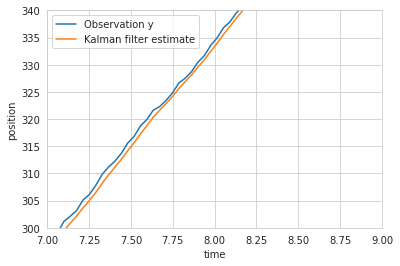

In [16]:
#Plot position
  
plt.plot(t,y)
plt.plot(t,filtered_state_means[:,0])

plt.xlabel('time')
plt.ylabel('position')
plt.legend(['Observation y', 'Kalman filter estimate'])

plt.xlim(xmin=7, xmax = 9)
plt.ylim(ymin=300, ymax = 340)

The Kalman filter does a better job of estimating the position than the velocity. This makes sense because we observe a noisy version of the position, but we do not observe the velocity. 

### Learning model parameters

Suppose that we only have guesses for the noise covariances.

In [17]:
state_cov_matrix_guess = [[1.0, 0.], [0., 1.0]]

obs_std_guess = 16.

We can define a `KalmanFilter` object with the guessed values and indicate that we want to use the EM algorithm to learn those parameters using `em_vars=['transition_covariance', 'observation_covariance']`

In [18]:
kf_learn = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix_guess, observation_covariance=obs_std_guess**2, transition_offsets=b.T, em_vars=['transition_covariance', 'observation_covariance'])

Applying the method `.em` uses the EM algorithm to estimate those parameters based on the observed data.

In [19]:
kf_learn = kf_learn.em(y, n_iter = 10)

Compare the learned values to the true values. This is a difficult optimization problem, so the estimates will not be perfect.

In [20]:
print('EM estimate of state covariance = ', kf_learn.transition_covariance, '. True covariance = ', state_cov_matrix)

EM estimate of state covariance =  [[87.39677787 28.3546885 ]
 [28.3546885  10.42870394]] . True covariance =  [[40.0, 0.0], [0.0, 10.0]]


In [21]:
print('EM estimate of observation variance = ', kf_learn.observation_covariance, '. True variance = ', obs_std**2)

EM estimate of observation variance =  [[223.91757305]] . True variance =  256


Use Estimated values to Update Kalman Filter

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [22]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = kf_learn.transition_covariance

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [23]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = np.sqrt(kf_learn.observation_covariance)

**Use the Kalman Filter to estimate the states with the estimated optimal model parameters**
 



Define a Kalman filter object with the known properties of the system

In [24]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [25]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter

(300.0, 340.0)

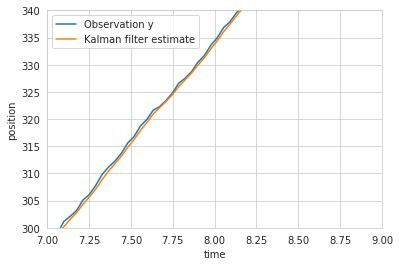

In [26]:
#Plot position
plt.plot(t,y)
plt.plot(t,filtered_state_means[:,0])

plt.xlabel('time')
plt.ylabel('position')
plt.legend(['Observation y', 'Kalman filter estimate'])

plt.xlim(xmin=7, xmax = 9)
plt.ylim(ymin=300, ymax = 340)

With the optimal parameter estimates, the Kalman filter does a better job in the sense the estimates are near the observed values.

**Predict future values**

In [27]:
#Predicting the next 25 positions

for n in range(25):
  x_prev = filtered_state_means[-1]
  x_next = np.matmul(A,x_prev) + b.T[-1]

  filtered_state_means = np.vstack((filtered_state_means, x_next))

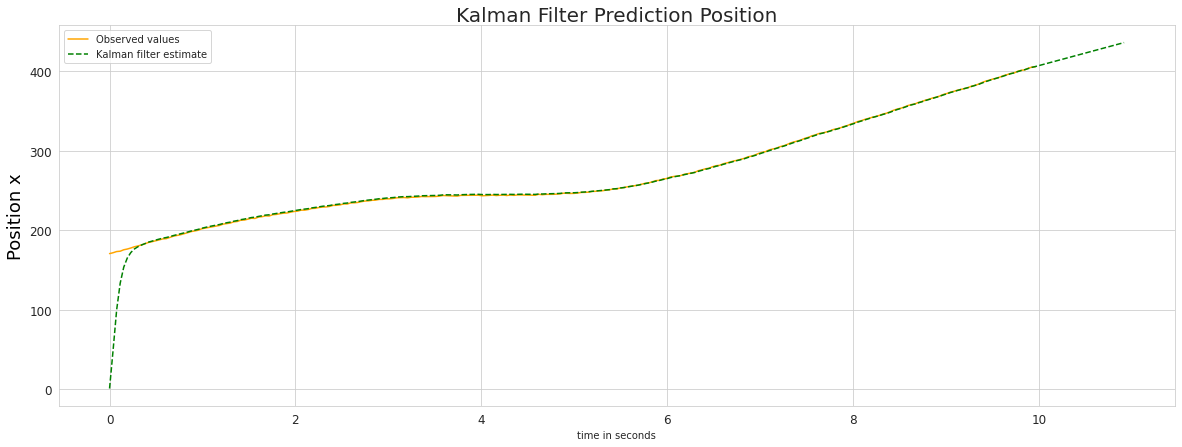

In [28]:
plt.figure(figsize = (20,7))

# variable to store next steps
t_25 = np.arange(n_timesteps + 25)*dt

#Plot position

plt.plot(t,y, 'orange')
plt.plot(t_25,filtered_state_means[:,0], 'g--')

# Set the labels, legends and title
plt.xlabel('time in seconds')
plt.ylabel('Position x', fontsize='18', color = 'black')
plt.legend(['Observed values', 'Kalman filter estimate'])
plt.title('Kalman Filter Prediction Position',  pad='4.0' , fontsize='20')

# set x and y tick sizes
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

#plt.xlim([8, 15])
#plt.ylim([300, 450])

The predictions of the next 25 positions seems to increase with increase in time. Kalman filter does a good job at predicting the next 25 step position of the pedestrian.

**Conculsion**

Overall, the Kalman Filter does a good job at predicting the next steps of the pedestrain. We can improve our model by combing y coordinates to model a 2D Kalman filter. 